In [1]:
# # run only to verify the dataset read op
# import numpy as np
# import pandas as pd

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/intel-image-classification'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2024-04-09 06:27:13.049152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 06:27:13.049286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 06:27:13.179278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
data_dir = "/kaggle/input/seg_train/seg_train/"
test_data_dir = "/kaggle/input/seg_test/seg_test/"

num_classes = 6
img_width = 150
img_height = 150
batch_size = 64
seed = 1

In [7]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [8]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [9]:
val_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [10]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    seed=seed,
    shuffle=False,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 3000 images belonging to 6 classes.


In [11]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

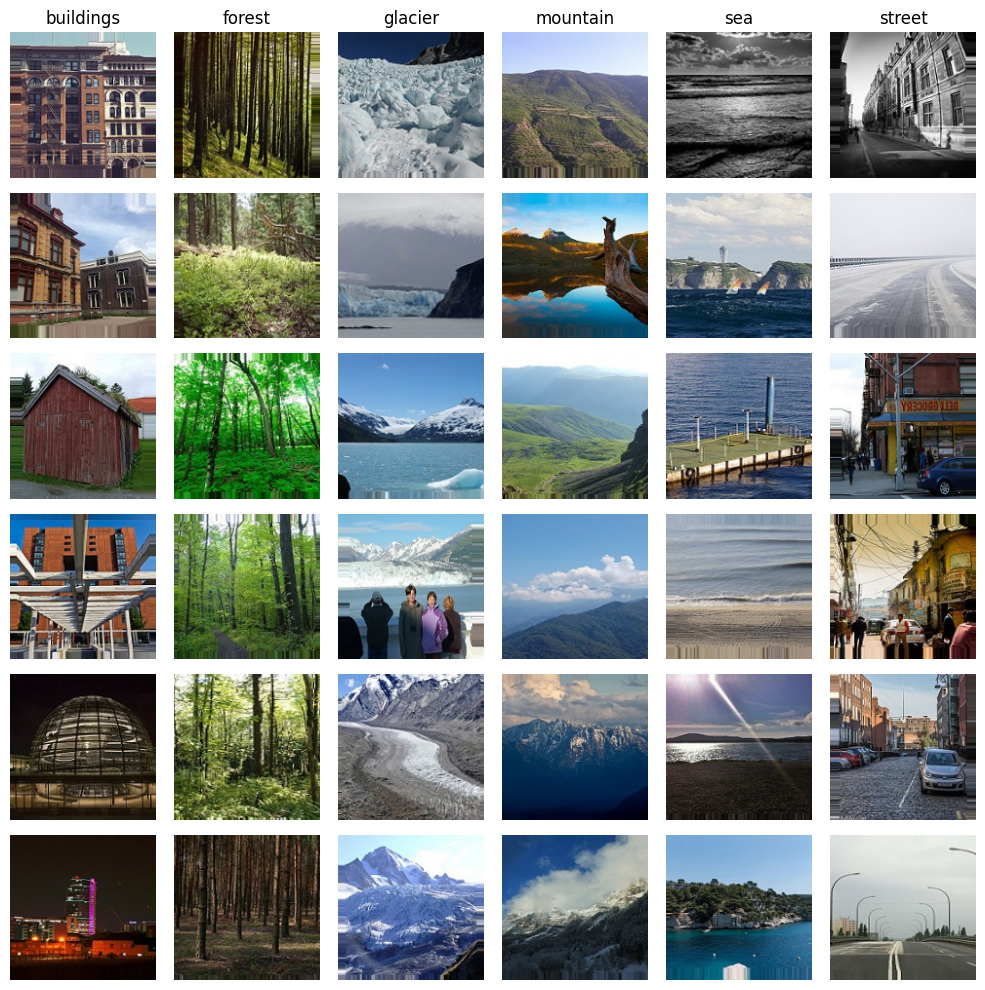

In [12]:
import matplotlib.pyplot as plt
import numpy as np

class_labels = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(6, 6, figsize=(10, 10))

for i, class_label in enumerate(class_labels):
    images, _ = next(iter(train_generator))
    
    # Get indices of images belonging to the current class
    class_indices = np.where(np.argmax(_, axis=1) == i)[0]
    
    # Get random indices for selecting 6 images
    random_indices = np.random.choice(class_indices, 6, replace=False)
    
    for j, index in enumerate(random_indices):
        # Display the j-th randomly selected image of the current class in the corresponding subplot
        ax = axes[j, i]
        ax.imshow(images[index])
        ax.axis('off')
        if j == 0:
            ax.set_title(class_label)

plt.tight_layout()
plt.show()

# Commonly used function definitions

In [13]:
def plot_learning_curve(history_):
    training_loss = history_.history['loss']
    validation_loss = history_.history['val_loss']
    training_accuracy = history_.history['accuracy']
    validation_accuracy = history_.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
def evaluate_on_test_dataset(model_):
    test_loss, test_accuracy = model_.evaluate(test_generator)
    print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

In [15]:
# this test set is to find the worst classified example (without having to use the test_generator)
test_set = list()
for i in range(47):
    x_, y_ = test_generator[i]
    test_set.extend(zip(x_, y_))

In [16]:
def plot_worst_classified_examples(preds):    
    # Find misclassified examples
    worst_misclassifications = dict()
    for i, (x, y_true) in enumerate(test_set):
        pred_label = np.argmax(preds[i])
        true_label = np.argmax(y_true)
        if pred_label != true_label:
            prob_diff = preds[i][pred_label] - preds[i][true_label]
            if true_label not in worst_misclassifications:
                worst_misclassifications[true_label] = (x, prob_diff, pred_label)
            else:
                if worst_misclassifications[true_label][1] < prob_diff:
                    worst_misclassifications[true_label] = (x, prob_diff, pred_label)

#     # prints images 1 by 1
#     for key, value in worst_misclassifications.items():
#         true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
#         pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[1])
#         plt.imshow(value[0])
#         plt.title(f"True: {true_lbl}, Pred: {pred_lbl}")
#         plt.axis('off')
#         plt.show()
    
    # prints images as subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    for idx, (key, value) in enumerate(worst_misclassifications.items()):
        true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
        pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[2])
        
        r, c = (0, idx) if idx <= 2 else (1, idx-3)
        axs[r, c].imshow(value[0])
        axs[r, c].set_title(f"True: {true_lbl}, Pred: {pred_lbl}")
        axs[r, c].axis('off')

    plt.tight_layout()
    plt.show()

# 1. A simple CNN Model (default lr, epochs=60)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator
)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/176 ━━━━━━━━━━━━━━━━━━━━ 46:45 16s/step - accuracy: 0.1250 - loss: 1.8443

I0000 00:00:1712644231.619320     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712644231.639035     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.5059 - loss: 1.2611

W0000 00:00:1712644353.507706     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 169s 875ms/step - accuracy: 0.5069 - loss: 1.2587 - val_accuracy: 0.6772 - val_loss: 0.8647
Epoch 2/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 560ms/step - accuracy: 0.6998 - loss: 0.8124 - val_accuracy: 0.7493 - val_loss: 0.7036
Epoch 3/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 555ms/step - accuracy: 0.7555 - loss: 0.6599 - val_accuracy: 0.7639 - val_loss: 0.6336
Epoch 4/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 555ms/step - accuracy: 0.7983 - loss: 0.5523 - val_accuracy: 0.7825 - val_loss: 0.6173
Epoch 5/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 555ms/step - accuracy: 0.8191 - loss: 0.5032 - val_accuracy: 0.8006 - val_loss: 0.5523
Epoch 6/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 550ms/step - accuracy: 0.8371 - loss: 0.4407 - val_accuracy: 0.8228 - val_loss: 0.4980
Epoch 7/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 104s 574ms/step - accuracy: 0.8488 - loss: 0.4189 - val_accuracy: 0.8260 - val_loss: 0.4768
Epoch 8/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 567ms/step - accuracy: 0.8626 - loss: 0.38

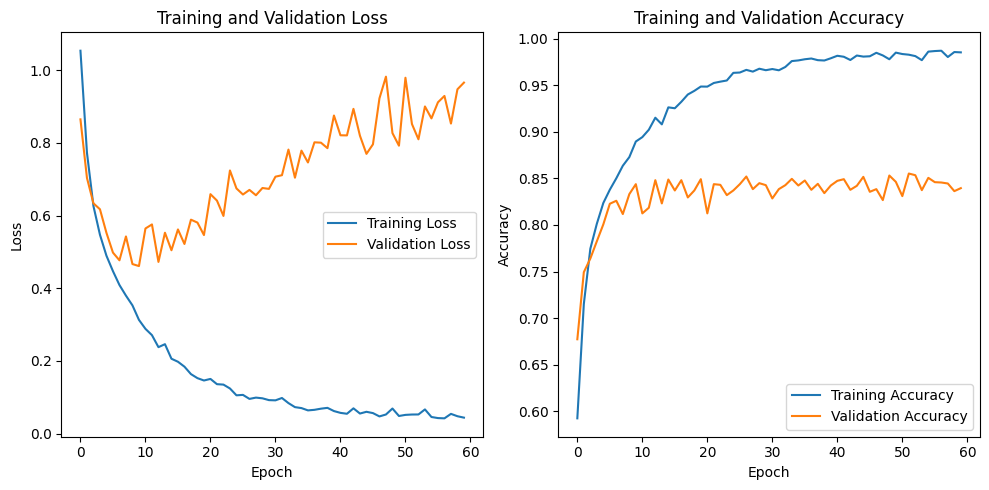

In [21]:
plot_learning_curve(history)

In [23]:
evaluate_on_test_dataset(model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - accuracy: 0.8182 - loss: 1.1289
Test Loss: 0.9942139983177185
Test Accuracy: 0.8396666646003723


In [24]:
predictions = model.predict(test_generator)

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step 

W0000 00:00:1712650618.122520     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step


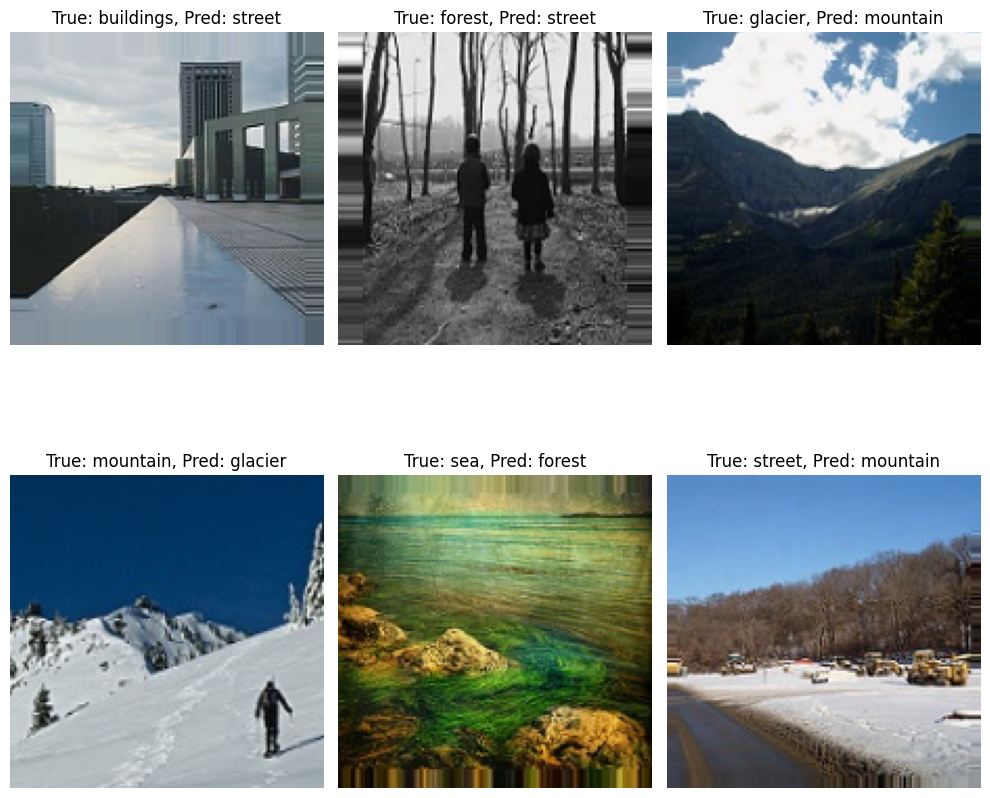

In [25]:
plot_worst_classified_examples(predictions)

# 2. A Model similar to Inception V3

In [26]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation

model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [27]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,661,606 (29.23 MB)

 Trainable params: 7,661,606 (29.23 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history2 = model2.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator
)

Epoch 1/60
  1/176 ━━━━━━━━━━━━━━━━━━━━ 1:21:09 28s/step - accuracy: 0.1250 - loss: 1.7856

W0000 00:00:1712650733.719928     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 93/176 ━━━━━━━━━━━━━━━━━━━━ 49s 601ms/step - accuracy: 0.3719 - loss: 1.5286

W0000 00:00:1712650788.926353     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.4343 - loss: 1.3872

W0000 00:00:1712650826.835879     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 147s 682ms/step - accuracy: 0.4348 - loss: 1.3860 - val_accuracy: 0.6131 - val_loss: 0.9264
Epoch 2/60


W0000 00:00:1712650853.103878     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 559ms/step - accuracy: 0.6095 - loss: 0.9680 - val_accuracy: 0.6769 - val_loss: 0.8403
Epoch 3/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 560ms/step - accuracy: 0.6622 - loss: 0.8586 - val_accuracy: 0.7393 - val_loss: 0.7033
Epoch 4/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 562ms/step - accuracy: 0.7351 - loss: 0.7147 - val_accuracy: 0.7864 - val_loss: 0.5808
Epoch 5/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 561ms/step - accuracy: 0.7626 - loss: 0.6454 - val_accuracy: 0.7989 - val_loss: 0.5610
Epoch 6/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 561ms/step - accuracy: 0.7902 - loss: 0.5924 - val_accuracy: 0.8074 - val_loss: 0.5359
Epoch 7/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 557ms/step - accuracy: 0.8022 - loss: 0.5465 - val_accuracy: 0.8242 - val_loss: 0.4964
Epoch 8/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 555ms/step - accuracy: 0.8164 - loss: 0.5133 - val_accuracy: 0.8203 - val_loss: 0.5118
Epoch 9/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 563ms/step - accuracy: 0.8368 - loss: 0.47

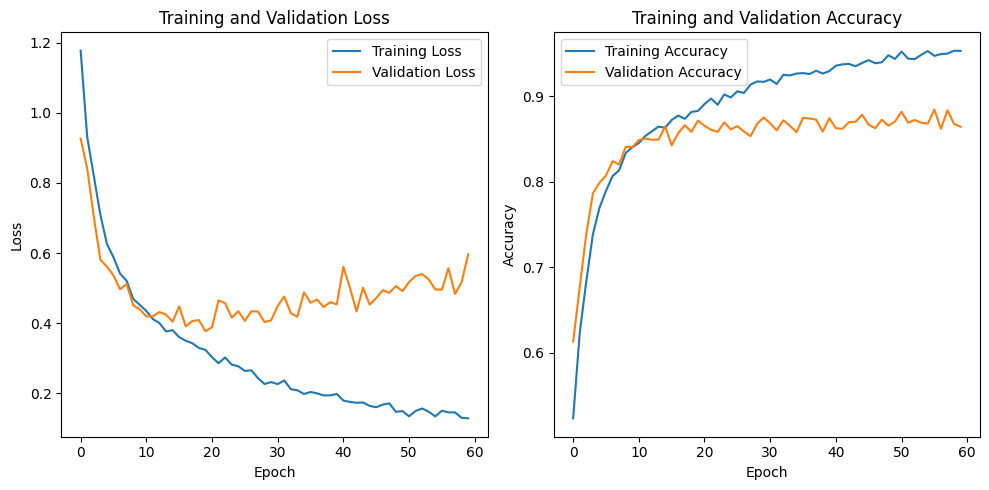

In [31]:
plot_learning_curve(history2)

In [32]:
evaluate_on_test_dataset(model2)

47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 677ms/step - accuracy: 0.9020 - loss: 0.5456
Test Loss: 0.6366627216339111
Test Accuracy: 0.8759999871253967


W0000 00:00:1712657056.712784     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [33]:
predictions2 = model2.predict(test_generator)

 2/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step  

W0000 00:00:1712657058.698379     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step


W0000 00:00:1712657080.680501     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


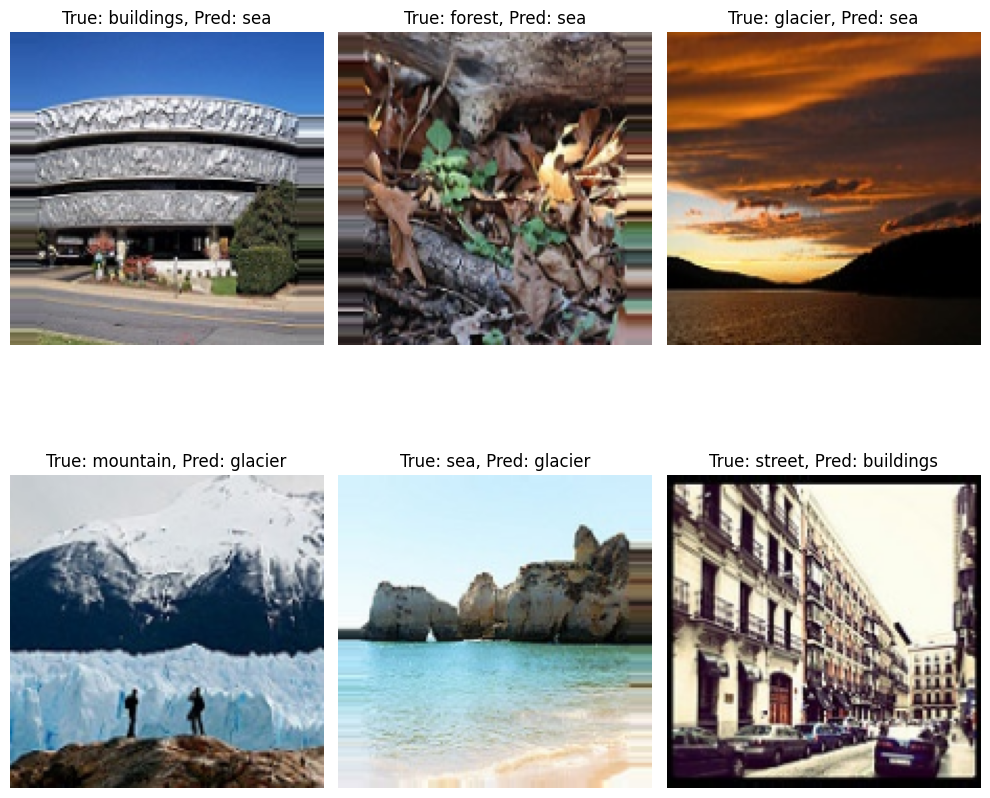

In [34]:
plot_worst_classified_examples(predictions2)